In [ ]:
pip install wandb

In [ ]:
import torch
from tqdm import trange, tqdm
import argparse
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

import pickle
from copy import deepcopy
import wandb
from datetime import date
from pathlib import Path

device="cuda"

In [ ]:
#Helper functions

def to_im(ten):
    return ten.cpu().detach().clone().squeeze(1).numpy()


def dround(ten, digits):
    a = 10 ^ digits
    return torch.round(ten * a) / a


def fitness_function(pop, targ):
    return (1 - torch.abs(pop.squeeze(1) - targ)).sum(axis=1) # the smaller the difference, the higher the fitness


def prepare_run(entity, project, args, folder_name="results"):
    import wandb

    #folder = get_folder()
    #args["location = get_location()

    run = wandb.init(config=args, entity=entity, project=project)

    today = date.today().strftime("%d-%m-%Y")
    folder = Path(folder_name) / run.name
    folder.mkdir(parents=True, exist_ok=True)

    return run, folder

def calc_strategy(phenotypes, selection_size, envs, args, curr_targ):
    #sample = np.random.choice(phenotypes, selection_size, replace=False)
    perm = torch.randperm(phenotypes.size(0))
    idx = perm[:selection_size]
    sample = phenotypes[idx]

    spec_A = 0
    spec_B = 0
    gen = 0
    low = 0
    #high = 0

    first_fitness = fitness_function(sample, envs[0]) #env A
    #curr_targ = (curr_targ + 1) % 2
    second_fitness = fitness_function(sample, envs[1]) #env B

    first_fitness = first_fitness / (int(args["num_genes_consider"]*args["grn_size"]))
    second_fitness = second_fitness / (int(args["num_genes_consider"]*args["grn_size"]))

    for i in range(len(first_fitness)):
      if (first_fitness[i] < 0.3 and second_fitness[i] < 0.3) or (0.3 <= first_fitness[i] <= 0.7 and second_fitness[i] < 0.3) or (first_fitness[i] < 0.3 and 0.3 <=second_fitness[i] <= 0.7):
        low += 1
      #if (first_fitness[i] > 0.7 and second_fitness[i] > 0.7) or (0.3 <= first_fitness[i] <= 0.7 and second_fitness[i] > 0.7) or (first_fitness[i] > 0.7 and 0.3 <=second_fitness[i] <= 0.7):
        #high += 1
      if (first_fitness[i] < 0.3 and second_fitness[i] > 0.7): 
        spec_B += 1
      if (first_fitness[i] > 0.7 and second_fitness[i] < 0.3):
        spec_A += 1
      if 0.3 <= first_fitness[i] <= 0.7 and 0.3 <= second_fitness[i] <= 0.7:
        gen += 1

    run.log({'low': low}, commit=False)
    #run.log({'high': high}, commit=False) #impossible
    run.log({'spec_A': spec_A}, commit=False)
    run.log({'spec_B': spec_B}, commit=False)
    run.log({'gen': gen}, commit=False)

    #print(first_fitness)
    #print(second_fitness)

    #print("low",low)
    #print("high", high)
    #print("specA",spec_A)
    #print("specB",spec_B)
    #print("gen",gen)

    #print(list(zip(first_fitnesses,second_fitnesses)))

    #torch.numel(first_fitnesses[first_fitnesses>0.7])

    #return(low, high,spec,gen)

In [ ]:
def get_phenotypes(args, pop, num_indv, complexities, if_comp):
  state = torch.zeros(num_indv, 1, args["grn_size"]).to(device)
  state[:, :, 0] = 1.0 # create input to the GRNs

  state_before = torch.zeros(num_indv, 1, args["grn_size"]).to(device) # keeping track of the last state
  for l in range(args["max_iter"]):
    state = torch.matmul(state, pop) # each matrix in the population is multiplied
    state = state * args["alpha"]
    state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
    # state = dround(state, 2)
    diffs=torch.abs(state_before - state).sum(axis=(1,2))
    which_repeat = torch.where(diffs == 0)
    if if_comp:
      complexities[which_repeat] += 1
    state_before = state

  if if_comp:
    return state, complexities
  else:
    return state

In [ ]:
# Evolve
def evolutionary_algorithm(args, title, folder):

    #Setting up

    pop = torch.randn((args["pop_size"], args["grn_size"], args["grn_size"])).to(device) # create population of random GRNs
    num_genes_fit=int(args["num_genes_consider"]*args["grn_size"])

    ones=torch.ones(1,int(num_genes_fit/2)).to(device)
    zeros=torch.zeros(1,int(num_genes_fit/2)).to(device)
    targA=torch.cat((ones,zeros),1)
    targB=torch.cat((zeros,ones),1)
    targs = [targA,targB]
    
    curr_targ = 0 # ID of which target is the current one
    previous_targ=curr_targ # will be used for measuring evolvability 
    ages = torch.zeros(args["pop_size"]).to(device)
    time_since_change = 0 # num gens since last environmental switch
    epoc = 0

    # Keeping track

    max_fits = [] 
    ave_fits = [] 
    st_div_fits = []
    ave_complex = [] 
    max_ages = [] 
    ave_ages = [] 
    diversities = [] 

    delta_fit_envchange_max = []
    delta_fit_envchange = []
    rebound_time = torch.zeros(int(args["num_generations"]/args["season_len"])).to(device)
    rebound_time_max = torch.zeros(int(args["num_generations"]/args["season_len"])).to(device)

    best_grns = []
    #champions = []

    for gen in trange(args["num_generations"]):

        time_since_change += 1

        # Generating phenotypes
        complexities = torch.zeros(args["pop_size"]).to(device)
        state, complexities=get_phenotypes(args, pop, args["pop_size"], complexities, if_comp= True)
        ave_complex.append(args["max_iter"]-complexities.mean().item()) # 0 = never converged, the higher the number the earlier it converged so true "complexity" is inverse of this value
        run.log({'average_complexity': args["max_iter"]-complexities.mean().item()}, commit=False)

        phenos = state[:,:,:num_genes_fit]

        #diversity among siblings of the same parent, from the previous generation
        if gen > 0:

          child_phenotypes = phenos[children_locs]
          reshaped=torch.reshape(child_phenotypes, (num_child, len(parent_locs), args["grn_size"]))
          stds=torch.std(reshaped,dim=(0))

          run.log({'std_of_children': stds.mean(1).mean().item()}, commit=False)

        # Evaluate fitnesses
        # ALTERNATIVE FITNESS FUNCTION

        num_clones=20

        c_genotypes = []
        c_phenotypes = []
        
        for c in range(num_clones): 
          
          # Make clones
          clones = pop.clone() # create one clone of each individual in the population
          
          # Mutate clones
          num_genes_mutate = int(args["grn_size"]*args["grn_size"]*len(clones) * args["mut_rate"])
          mylist = torch.zeros(args["grn_size"]*args["grn_size"]*len(clones), device=device)
          mylist[:num_genes_mutate] = 1
          shuffled_idx = torch.randperm(args["grn_size"]*args["grn_size"]*len(clones), device=device)
          mask = mylist[shuffled_idx].reshape(len(clones),args["grn_size"],args["grn_size"]) #select genes to mutate
          clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * args["mut_size"]  # mutate only at certain genes

          # Get clone phenotypes
          clone_states = get_phenotypes(args, clones, args["pop_size"], complexities, if_comp= False)
          clone_phenos = clone_states[:,:,:num_genes_fit]

          # Save results
          c_genotypes.append(clones)
          c_phenotypes.append(clone_phenos)
                
        c_genotypes = torch.stack(c_genotypes)
        c_phenotypes = torch.stack(c_phenotypes)

        # Calculate fitness from phenotypes of clones
        c_phenotypes=torch.squeeze(c_phenotypes)
        tops=c_phenotypes[: , :  , :int(num_genes_fit/2)].sum(axis=-1, keepdims=True)
        bots=c_phenotypes[: , :  , int(num_genes_fit/2):].sum(axis=-1, keepdims=True)
        
        across_envs=abs(tops-bots).sum(axis=0) # sum of differences across clones between top and bottom half (i.e. envs). we want this to be high! we want the tops and bots to be different
        across_clones=abs(tops.sum(axis=0) - bots.sum(axis=0)) # for each individual, difference between tops and bots across the clones. you want this to be low
        across_envs=across_envs/(int(num_genes_fit/2)*num_clones) # number of genes/2 times number of clones
        across_clones=1-(across_clones/(int(num_genes_fit/2)*num_clones)) # number of genes/2 times number of clones, also the lower the better so let's flip
       
        newfitnesses=across_envs + across_clones - 1
        fitnesses=torch.squeeze(newfitnesses)

  
        if previous_targ!=curr_targ: # checking reduction in fitness right after env change
          delta_fit_envchange.append((fitnesses.mean().item())/(ave_fits[-1]))
          run.log({'delta_fit_envchange': (fitnesses.mean().item())/(ave_fits[-1])}, commit=False)
          delta_fit_envchange_max.append((fitnesses.max().item())/(max_fits[-1]))
          run.log({'delta_fit_envchange_max': (fitnesses.max().item())/(max_fits[-1])}, commit=False)

        #print(epoc)
        if epoc != 0: # if it is not the first epoc
          if rebound_time[epoc] == 0: # if for this epoc, fitness rebound hasn't happened yet
            if ave_fits[(-1*time_since_change)] <= fitnesses.mean().item(): # if fitness rebounded this generation
              rebound_time[epoc] = time_since_change
              # if reound_time is 0 somewhere, that means that previous good fitness wasn't found in this epoc. 
              # if there is a 0 right after, that means that the new "max" (final fitness before env change) was also not recovered. 
              # note the shift in frame of reference

          if rebound_time_max[epoc] == 0: # if for this epoc, fitness rebound hasn't happened yet
            if max_fits[(-1*time_since_change)] <= fitnesses.max().item(): # if fitness rebounded this generation
              rebound_time_max[epoc] = time_since_change
              # if reound_time is 0 somewhere, that means that previous good fitness wasn't found in this epoc. 
              # if there is a 0 right after, that means that the new "max" (final fitness before env change) was also not recovered. 
              # note the shift in frame of reference
          if time_since_change == args["season_len"]:
            run.log({'rebound_time': rebound_time[epoc]}, commit=False)
            run.log({'rebound_time_max': rebound_time_max[epoc]}, commit=False)
        
        max_fits.append(fitnesses.max().item()) # keeping track of max fitness
        ave_fits.append(fitnesses.mean().item()) # keeping track of average fitness
        st_div_fits.append(fitnesses.std().item())
        run.log({'max_fits': fitnesses.max().item()}, commit=False)
        run.log({'ave_fits': fitnesses.mean().item()}, commit=False)
        run.log({'st_div_fits': fitnesses.std().item()}, commit=False)

        #if gen == (args["num_generations"] - 1):
        selection_size=int(args["pop_size"]*0.1)
        calc_strategy(phenos, selection_size, targs, args, curr_targ)

        # Selection
        perm = torch.argsort(fitnesses, descending=True)
        parent_locs = perm[:args["truncation_size"]] # location of top x parents in the array of individuals
        children_locs = perm[args["truncation_size"]:] # location of individuals that won't survive and hence will be replaced by others' children

        #champions.append(state[perm[0]].detach().clone().cpu().squeeze(0).numpy()) # keeping tract of best solution's output
        best_grns.append(pop[perm[0]].detach().clone().cpu()) # keeping tract of best solution
        #run.log({'champions': state[perm[0]].detach().clone().cpu().squeeze(0).numpy()}, commit=False)
        #run.log({'best_grns': pop[perm[0]].detach().clone().cpu()}, commit=False)

        ages[parent_locs] += 1 # updating the ages of the individuals
        ages[children_locs] = 0

        parents = pop[parent_locs].detach().clone() # access parents' matricies
        num_child = int(args["pop_size"]/args["truncation_size"]) - 1
        children = parents.repeat([num_child, 1, 1]) # create copies of parents

        # Mutation
        num_genes_mutate = int(args["grn_size"]*args["grn_size"]*len(children) * args["mut_rate"])
        mylist = torch.zeros(args["grn_size"]*args["grn_size"]*len(children), device=device)
        mylist[:num_genes_mutate] = 1
        shuffled_idx = torch.randperm(args["grn_size"]*args["grn_size"]*len(children), device=device)
        mask = mylist[shuffled_idx].reshape(len(children),args["grn_size"],args["grn_size"]) #select genes to mutate
        children = children + (children*mask)*torch.randn(size=children.shape, device=device) * args["mut_size"]  # mutate only children only at certain genes

        pop[children_locs] = children # put children into population


        max_ages.append(ages.max().item())
        ave_ages.append(ages.mean().item())
        run.log({'max_ages': ages.max().item()}, commit=False)
        run.log({'ave_ages': ages.mean().item()}, commit=False)

        d=torch.mean(torch.std(pop,unbiased=False, dim=0))
        diversities.append(d)
        run.log({'diversities': d}, commit=True)

        previous_targ=curr_targ
        if gen % args["season_len"] == args["season_len"] - 1: # flip target
            curr_targ = (curr_targ + 1) % 2
            #print(time_since_change)
            time_since_change = 0
            epoc += 1



    stats = {}
    stats["max_fits"] = max_fits
    stats["ave_fits"] = ave_fits
    stats["st_div_fits"] = st_div_fits
    stats["ave_complex"] = ave_complex
    stats["delta_fit_envchange"] = delta_fit_envchange
    stats["delta_fit_envchange_max"] = delta_fit_envchange_max
    stats["rebound_time"] = rebound_time
    stats["rebound_time_max"] = rebound_time_max
    #stats["champions"] = champions
    stats["max_ages"] = max_ages
    stats["ave_ages"] = ave_ages
    stats["best_grns"] = best_grns
    stats["diversities"] = diversities
    with open(f"{folder}/basic_{title}.pkl", "wb") as f:
        pickle.dump(stats, f)



In [ ]:
args = {}

#parser.add_argument('-grn_size', type=int, default=50, help="GRN size") # number of genes in the GRN
args["grn_size"] = 50
#parser.add_argument('-pop_size', type=int, default=1000, help="Population size")
args["pop_size"] = 1000
#parser.add_argument('-alpha', type=int, default=10, help="Alpha for sigmoid function")
args["alpha"] = 10
#parser.add_argument('-num_genes_consider', type=float, default=0.5, help="proportion of genes considered for fitness")
args["num_genes_consider"] = 1
#parser.add_argument('-mut_rate', type=float, default=0.1, help="rate of mutation (i.e. number of genes to mutate)")
args["mut_rate"] = 0.1
#parser.add_argument('-mut_size', type=float, default=0.5, help="size of mutation")
args["mut_size"] = 0.5
#parser.add_argument('-num_generations', type=int, default=100000, help="number of generations to run the experiment for") # number of generations
args["num_generations"] = 500
#parser.add_argument('-truncation_prop', type=float, default=0.2, help="proportion of individuals selected for reproduction")
args["truncation_prop"] = 0.2
#parser.add_argument('-max_age', type=int, default=30, help="max age at which individual is replaced by its kid")
args["max_age"] = 100000000000
#parser.add_argument('-season_len', type=int, default=100, help="number of generations between environmental flips")
args["season_len"] = 20
#parser.add_argument('-proj', type=str, default="EC_final_project", help="Name of the project (for wandb)")
args["proj"] = "phd_chapt_3"
#parser.add_argument('-exp_type', type=str, default="BASIC", help="Name your experiment for grouping")
args["exp_type"] = "testing"

#parser.add_argument('-crossover', type=str, default="NO", help="Options: NO, uniform, twopoint")
args["crossover"] = "NO"
#parser.add_argument('-crossover_freq', type=float, default=0.5, help="number of individuals that will undergo crossover")
args["crossover_freq"] = 0.5
#parser.add_argument('-adaptive_mut', type=bool, default=False, help="if you want adaptive mutation rate")
args["adaptive_mut"] = False
#parser.add_argument('-meta_mut_rate', type=float, default=0.01, help="how much you increase or decrease mut_size and mut_rate")
args["meta_mut_rate"] = 0.01

#args = parser.parse_args()

print("running code")

args["max_iter"] = int(3*args["grn_size"]) # "Maximum number of GRN updates") # number of times gene concentrations are updated to get phenotype

args["truncation_size"]=int(args["truncation_prop"]*args["pop_size"])

print(args)

args["num_crossover"] = int(args["crossover_freq"] * args["pop_size"]) #how many individuals will be involved in crossover

#assert (
    #args["num_crossover"] % 2 == 0
#), f"Error: select different crossover_freq" #: received {args["num_crossover"]}"
assert (
    args["pop_size"] % args["truncation_size"] == 0
), "Error: select different trunction_prop" #received {args["pops_size"]}"

assert (
    int(args["num_genes_consider"]*args["grn_size"]) % 2 == 0
), "Error: select different num_genes_consider, needs to be a multiple of 2"


running code
{'grn_size': 50, 'pop_size': 1000, 'alpha': 10, 'num_genes_consider': 1, 'mut_rate': 0.1, 'mut_size': 0.5, 'num_generations': 500, 'truncation_prop': 0.2, 'max_age': 100000000000, 'season_len': 20, 'proj': 'phd_chapt_3', 'exp_type': 'testing', 'crossover': 'NO', 'crossover_freq': 0.5, 'adaptive_mut': False, 'meta_mut_rate': 0.01, 'max_iter': 150, 'truncation_size': 200}


In [ ]:
run, folder = prepare_run("molanu", args["proj"], args)
newfitnesses =evolutionary_algorithm(args, "place_holder_title", folder)

ave_ages,▁▁▂▄▄▄▅▇▅▅▆▆▆▆▆▅█▅▄▆▆▆▅▆▅▅▅▅▅▄▇▄▄▅▆▅▄▅▇▆
ave_fits,▁▁▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
average_complexity,▁▆████▇███▆█▇██▇██████▅████▆█▆██▇███████
delta_fit_envchange,▂█▃▅▃▇▄▁▃▅▁▄▇▅
delta_fit_envchange_max,▄█▂▃▁▅▄▃▃▅▃▃▃▃
diversities,██▂▄▂▁▁▁▂▂▃▃▃▄▄▄▅▅▄▄▃▃▃▃▃▂▃▃▄▃▃▃▃▄▄▄▅▅▆▆
gen,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
low,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_ages,▁▂▂▃▂▃▂▄▄▂▄▄▃▄▂▃█▄▅▄▂▅▃▄▄▄▄▃▂▂▄▂▄▄▄▄▂▃▄▃
max_fits,▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
rebound_time,▃▁▂▁▂▁▁█▂▁▂▁▁


100%|██████████| 500/500 [05:02<00:00,  1.66it/s]


In [ ]:
402.57/60 #mins

6.7095

In [ ]:
#1 hour for 10
#10 hours for 100

In [6]:
device="cpu"

In [3]:
import io

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch

In [4]:
class CPU_Unpickler(pickle.Unpickler):
    import io
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

class FakeArgs:
    """
    A simple class imitating the args namespace
    """

    def __repr__(self):
        attrs = vars(self)
        return "\n".join([f"{k}: {v}" for k, v in attrs.items()])

def get_phenotypes(args, pop, num_indv, complexities, if_comp):
  state = torch.zeros(num_indv, 1, args.grn_size).to(device)
  state[:, :, 0] = 1.0 # create input to the GRNs

  state_before = torch.zeros(num_indv, 1, args.grn_size).to(device) # keeping track of the last state
  for l in range(args.max_iter):
    state = torch.matmul(state, pop) # each matrix in the population is multiplied
    state = state * args.alpha
    state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
    # state = dround(state, 2)
    diffs=torch.abs(state_before - state).sum(axis=(1,2))
    which_repeat = torch.where(diffs == 0)
    if if_comp:
      complexities[which_repeat] += 1
    state_before = state

  if if_comp:
    return state, complexities
  else:
    return state

In [5]:
# open a file, where you stored the pickled data
#file = open('results/fresh-frost-6/basic_place_holder_title.pkl', 'rb')
#file = open('results/sweet-peony-128/basic_place_holder_title.pkl', 'rb')
#file = open('lucky_rooster.pkl', 'rb')
#file = open('thriving_lamp.pkl', 'rb')
file = open('cheerful_kumquat.pkl', 'rb')

# dump information to that file
data = pickle.load(file)
#data = CPU_Unpickler(file).load()

In [6]:
data.keys()

dict_keys(['max_fits', 'ave_fits', 'st_div_fits', 'ave_complex', 'delta_fit_envchange', 'delta_fit_envchange_max', 'rebound_time', 'rebound_time_max', 'max_ages', 'ave_ages', 'best_grns', 'diversities', 'low', 'spec_A', 'spec_B', 'gen', 'kid_stds', 'args_used'])

In [7]:
check_at=-1

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


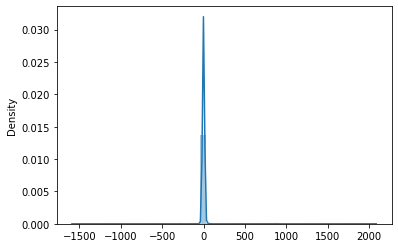

In [8]:
#sns.distplot(torch.flatten(data["best_grns"][0])) #density=True, alpha = 0.3)
#sns.distplot(torch.flatten(data["best_grns"][-1]))
sns.distplot(torch.flatten(data["best_grns"][check_at]))
#plt.hist(torch.flatten(data["best_grns"][-1]), density=True)

In [9]:
final_weights=data["best_grns"][check_at]
#final_weights = np.clip(final_weights,-0.001,0.001)

In [ ]:
#for row in final_weights:
  #print("|".join([ f"{el:.5f}"[4:].replace("0"," ") for el in row.tolist()]))

In [10]:
args = data["args_used"]

In [12]:
device="cuda"

In [13]:
best_pheno=get_phenotypes(args, final_weights.to(device), 1, 3, False)

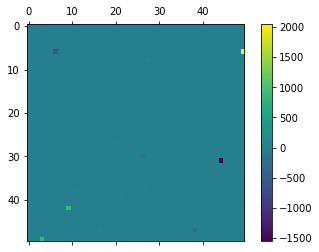

In [14]:
#plt.matshow(data["best_grns"][-1])
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(final_weights)
fig.colorbar(cax)

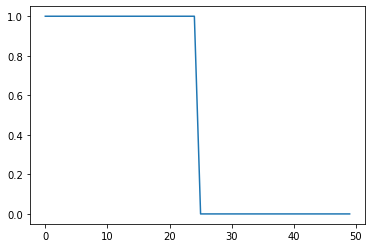

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.plot(best_pheno[0][0].cpu())
#fig.colorbar(cax)

In [16]:
num_clones=20
complexities = 0
num_genes_fit = 50

clones = data["best_grns"][check_at].to(device).repeat([num_clones, 1, 1]) # create copies of parents

# Mutate clones
num_genes_mutate = int(args.grn_size*args.grn_size*len(clones) * args.mut_rate)
mylist = torch.zeros(args.grn_size*args.grn_size*len(clones), device=device)
mylist[:num_genes_mutate] = 1
shuffled_idx = torch.randperm(args.grn_size*args.grn_size*len(clones), device=device)
mask = mylist[shuffled_idx].reshape(len(clones),args.grn_size,args.grn_size) #select genes to mutate
clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * args.mut_size  # mutate only children only at certain genes

# Get clone phenotypes
clone_states=get_phenotypes(args, clones, num_clones, complexities, if_comp= False)
clone_phenos = clone_states[:,:,:num_genes_fit]
        
#c_genotypes = torch.stack(c_genotypes)
#c_phenotypes = torch.stack(c_phenotypes)

# Calculate fitness from phenotypes of clones
#c_phenotypes=torch.squeeze(c_phenotypes)
#tops=c_phenotypes[: , :  , :int(num_genes_fit/2)].sum(axis=-1, keepdims=True)
#bots=c_phenotypes[: , :  , int(num_genes_fit/2):].sum(axis=-1, keepdims=True)

In [17]:
clones.size()

torch.Size([20, 50, 50])

In [18]:
torch.squeeze(clone_phenos).size()

torch.Size([20, 50])

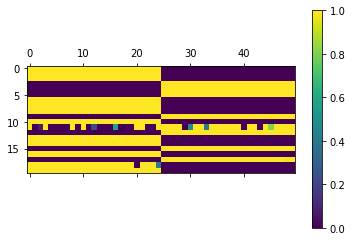

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(torch.squeeze(clone_phenos).cpu())
fig.colorbar(cax)

In [20]:
def get_internal_states(grn):
  grn=grn.to(device)
  states=[]
  state = torch.zeros(1, 1, args.grn_size).to(device)
  state[:, :, 0] = 1.0 # create input to the GRNs

  state_before = torch.zeros(1, 1, args.grn_size).to(device) # keeping track of the last state
  for l in range(args.max_iter):
    states.append(state)
    state = torch.matmul(state, grn) # each matrix in the population is multiplied
    state = state * args.alpha
    state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
    # state = dround(state, 2)
    diffs=torch.abs(state_before - state).sum(axis=(1,2))
    which_repeat = torch.where(diffs == 0)
    state_before = state

  states=torch.stack(states)
  states=torch.flatten(states,start_dim=1)
  return states


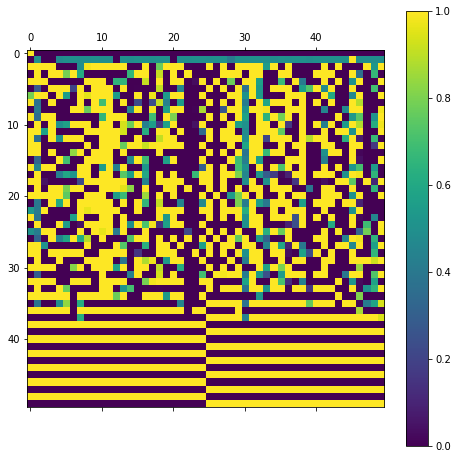

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(get_internal_states(data["best_grns"][check_at]).cpu()[:50,:])
fig.colorbar(cax)

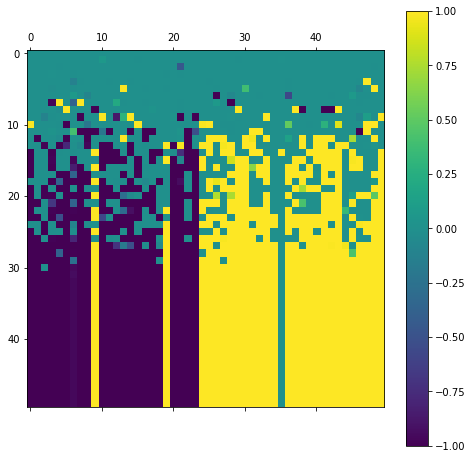

In [ ]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(get_internal_states(data["best_grns"][-1]).cpu()[:50,:]-get_internal_states(clones[2]).cpu()[:50,:])
fig.colorbar(cax)

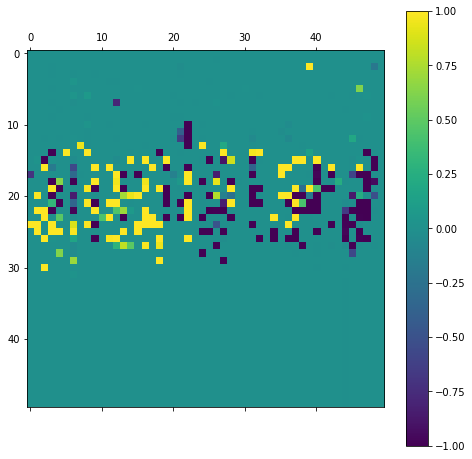

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(get_internal_states(data["best_grns"][-1]).cpu()[:50,:]-get_internal_states(clones[0]).cpu()[:50,:])
fig.colorbar(cax)

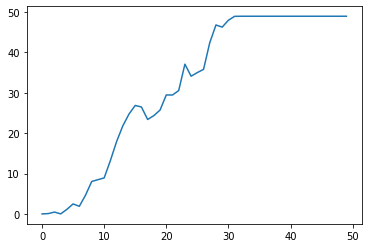

In [ ]:
disagreement = get_internal_states(data["best_grns"][-1]).cpu()[:50,:]-get_internal_states(clones[2]).cpu()[:50,:]
plt.plot(disagreement.abs().sum(axis=1))

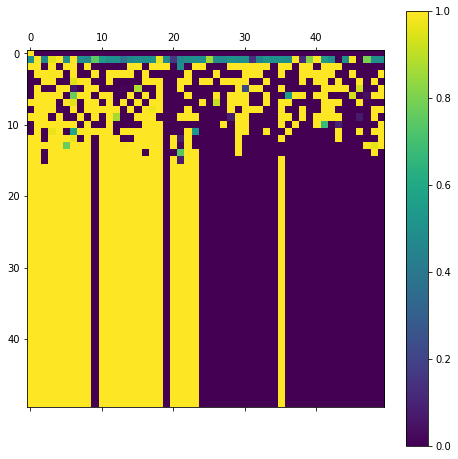

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(get_internal_states(clones[2]).cpu()[:50,:])
fig.colorbar(cax)

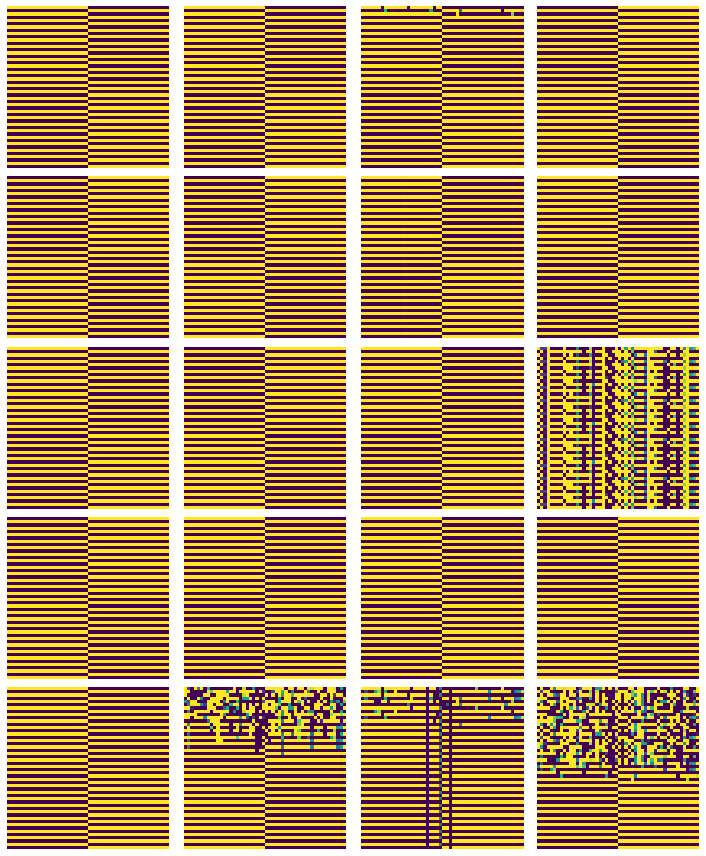

In [22]:
fig,axs = plt.subplots(nrows=5,ncols=4, figsize=(10,12))
for i,ax in enumerate(axs.flatten()):
  #start = get_internal_states(clones[i]).cpu()[:50,:]
  #end = get_internal_states(clones[i]).cpu()[-50:,:]
  #ax.imshow(torch.vstack((start, end)), interpolation="nearest")
  ax.imshow(get_internal_states(clones[i]).cpu()[-50:,:], interpolation="nearest")
  ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

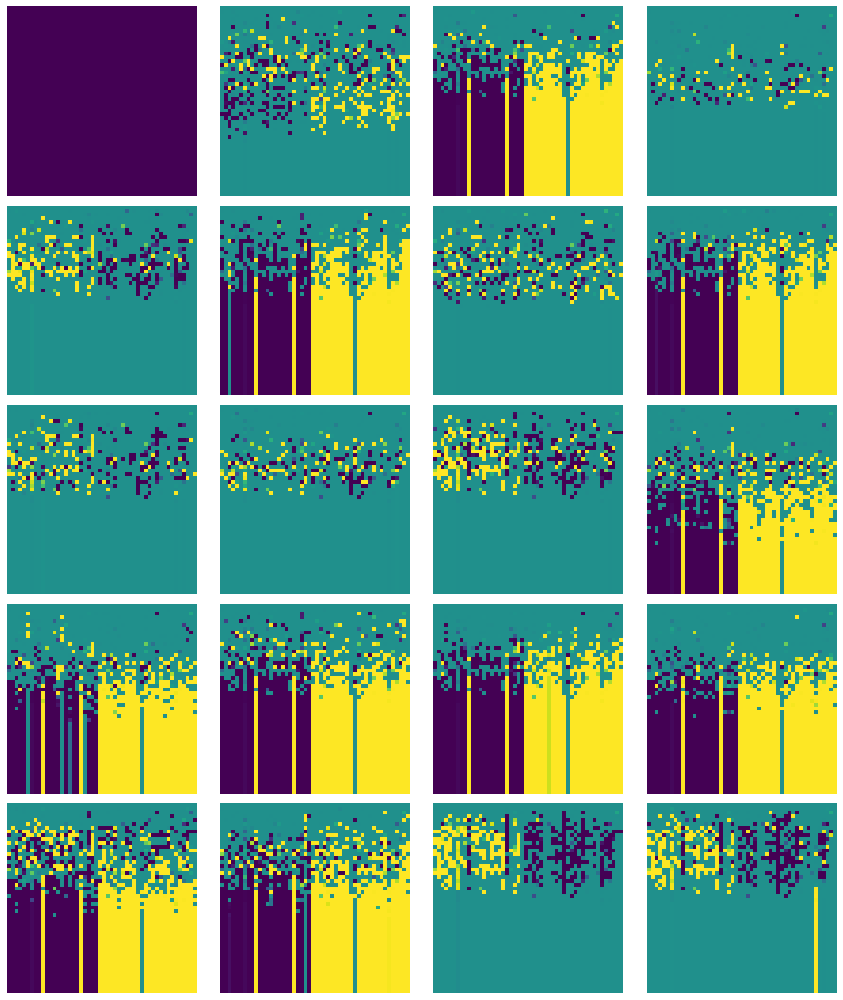

In [ ]:
fig,axs = plt.subplots(nrows=5,ncols=4, figsize=(12,14))
for i,ax in enumerate(axs.flatten()):
  #start = get_internal_states(clones[i]).cpu()[:50,:]
  #end = get_internal_states(clones[i]).cpu()[-50:,:]
  #ax.imshow(torch.vstack((start, end)), interpolation="nearest")
  #ax.imshow(get_internal_states(clones[i]).cpu()[:4,:], interpolation="nearest")
  #cax = ax.matshow(get_internal_states(data["best_grns"][-1]).cpu()[:50,:]-get_internal_states(clones[i]).cpu()[:50,:])
  cax = ax.matshow(get_internal_states(clones[0]).cpu()[:50,:]-get_internal_states(clones[i]).cpu()[:50,:])
  ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

In [ ]:
types=np.array([0,0,1,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,0,0])
clones_A=clones[np.where(types == 0)]
clones_B=clones[np.where(types == 1)]

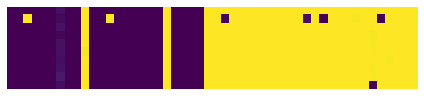

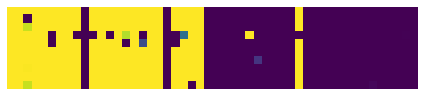

In [ ]:
fadsfa = 31
a = torch.vstack([get_internal_states(clones_A[i]).cpu()[fadsfa:fadsfa+1,:] for i in range(10)])
b = torch.vstack([get_internal_states(clones_B[i]).cpu()[fadsfa:fadsfa+1,:] for i in range(10)])

plt.imshow(a)
plt.axis("off")
plt.tight_layout()
plt.show()

plt.imshow(b)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
fig,axs = plt.subplots(nrows=10,ncols=1, figsize=(8,4))
for i,ax in enumerate(axs.flatten()):
  #start = get_internal_states(clones[i]).cpu()[-1:,:]
  #end = get_internal_states(clones[i]).cpu()[2:3,:]
  #ax.imshow(torch.vstack((start, end)), interpolation="nearest")
  ax.imshow(get_internal_states(clones_B[i]).cpu()[2:3,:], interpolation="nearest")
  ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(hspace=0.,wspace=0.)
plt.show()

-------

In [ ]:
divmod(torch.abs(final_weights).argmax().item(), final_weights.shape[1]) #coordinates of highest deviation from 0

(26, 5)

In [ ]:
torch.abs(final_weights).mean(0).argmax() # which column on average highest deviation from 0

tensor(5)

In [ ]:
torch.abs(final_weights).mean(1).argmax() # which row on average highest deviation from 0

tensor(26)

In [ ]:
tops=torch.topk(torch.abs(final_weights).flatten(), 3).indices
for t in tops:
  print(t.item())
  print(divmod(t.item(), final_weights.shape[1]))

1305
(26, 5)
1811
(36, 11)
205
(4, 5)


In [ ]:
def calc_rob(pop, ssize, rounds, args):
    ave_exp_rob = []
    ave_fit_rob = []
    ave_ben_mut = []
    ave_del_mut = []
    sample = np.random.choice(pop, ssize, replace=False)
    for p in sample:
        exp_rob = 0
        fit_rob = 0
        ben_mut = 0
        del_mut = 0
        ori_grn_out = p.grn_output()
        ori_fitness = fitness_function(ori_grn_out,envs,state,args)
        for mut in range(rounds):
            sample_cp = deepcopy(p)
            sample_cp.mut_edge()
            new_grn_out = sample_cp.grn_output()
            new_fitness = fitness_function(new_grn_out,envs,state,args)
            if np.array_equal(ori_grn_out,new_grn_out):
                exp_rob += 1
                fit_rob += 1
            else:
                if new_fitness > ori_fitness:
                    ben_mut +=1
                elif new_fitness < ori_fitness:
                    del_mut += 1
                else:
                    fit_rob += 1
        if exp_rob > 0:
            ave_exp_rob.append(exp_rob/rounds)
        else:
            ave_exp_rob.append(exp_rob)
        if fit_rob > 0:
            ave_fit_rob.append(fit_rob/rounds)
        else:
            ave_fit_rob.append(fit_rob)
        if del_mut > 0:
            ave_del_mut.append(del_mut/(rounds - fit_rob))
        else:
            ave_del_mut.append(del_mut)
        if ben_mut > 0:
            ave_ben_mut.append(ben_mut/(rounds - fit_rob))
        else:
            ave_ben_mut.append(ben_mut)
    return(np.average(ave_exp_rob), np.average(ave_fit_rob), np.average(ave_ben_mut), np.average(ave_del_mut))


In [ ]:
def epi(x):
  mmax=0.5
  mmin=-0.5
  k=3

  x=x-mmax
  a=(mmax+mmax)/(math.e**(mmax*k) - math.e**(mmin*k))
  b=mmin-a*math.e**(mmin*k)

  y=a*math.e**(k*x) + b

  return y + mmax

In [ ]:
epi(0.5)

0.18242552380635635

In [ ]:
import networkx as nx
A=np.array(data["best_grns"][-1])
G = nx.from_numpy_array(A)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 100]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=0.2, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

from networkx.convert import from_edgelist

G = nx.DiGraph()

for i in range(A.shape[0]):
  for j in range(A.shape[1]):
    if np.abs(A[i,j]) > 1:
      G.add_edge(i,j, weight=A[i,j])

nx.draw(G)

edges=[]
for i in range(A.shape[0]):
  for j in range(A.shape[1]):
    if np.abs(A[i,j]) > 1:
      edges.append((i,j,A[i,j]))
print(edges)

with open("edges.csv","w") as f:
  f.write("source, target, type, weight\n")
  for fr, to, we in edges:
    f.write(f"{fr},{to},directed,{we:.3f}\n")